In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Data

In [2]:
y_ = [198, 193]
n_ = [19934, 19942]

## Model specification
A parameterization for the priors on alpha and beta is

a=μη and b=(1−μ)η

μ = y / n = (198 + 192 / 19934 + 19942)

n* = (19934 + 199942) / 2

μ = Beta(1,1)

η = Logistic(log(n), 1)

p ~ Beta(a, b)

Y ~ Binomial(n, p)

λ = η / (n* + η)


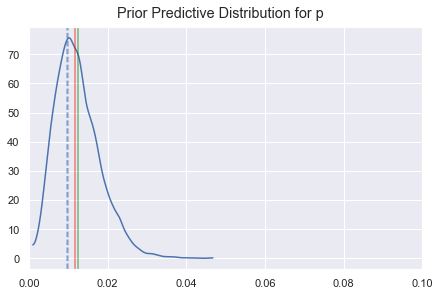

In [3]:
with pm.Model() as model_a:
    # Hyper-priors # n_star=1, alpha=1, beta=9 are good
    # 10, 1, 9 with 1/2 is good
    # 20000, 2, 98 with 1/5 is good
    # 20000, 2, 2, with 1/5 is good
    # 1000, 2, 2 with 1/4 is good

    N = pm.Data("N", n_)
    Y = pm.Data("Y", y_)

    n_star = 500
    mu = pm.Beta("mu", alpha=20, beta=1600)
    log_nu = pm.Logistic("log_nu", pm.math.log(n_star), 1/20)
    nu = pm.math.exp(log_nu)

    alpha = pm.Deterministic("alpha", mu*nu)    
    beta = pm.Deterministic("beta", (1-mu)*nu)

    # Shrinkage
    lamb = pm.Deterministic("lamb", nu / (n_star + nu))

    # Priors
    p = pm.Beta("p", alpha=alpha, beta=beta, shape=2)

    # Calculations of interest
    pdiff = pm.Deterministic("pdiff", p[0] - p[1])
    RR = pm.Deterministic("RR", p[0]/p[1])

    _ = pm.Binomial("y", n=N, p=p, observed=Y)

    prior_checks = pm.sample_prior_predictive(samples=6000)
    pm.plot_dist(prior_checks["p"])
    plt.axvline(y_[0] / n_[0], linestyle="--", alpha=0.5)
    plt.axvline(y_[1] / n_[1], linestyle="--", alpha=0.5)
    plt.axvline(np.median(prior_checks["p"]), color="red", alpha=0.5)
    plt.axvline(np.mean(prior_checks["p"]), color="green", alpha=0.5)

    plt.suptitle("Prior Predictive Distribution for p")
    plt.xlim(0.0,0.1)


## Posterior sampling

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_27553/2646678404.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_a = pm.sample(2000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, log_nu, mu]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 84 seconds.


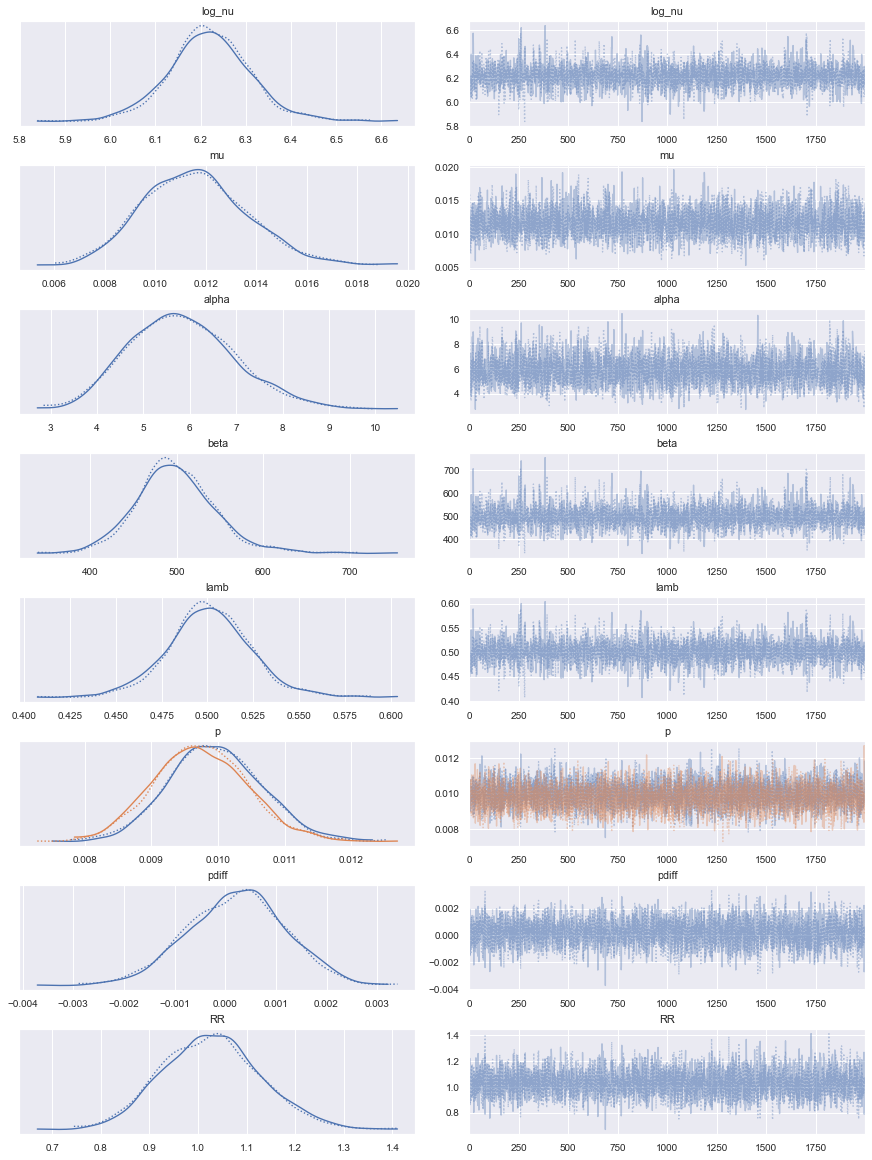

In [4]:
with model_a:
    trace_a = pm.sample(2000, target_accept=0.9)
    pm.plot_trace(trace_a)

## Forest Plots for Parameters of Interest

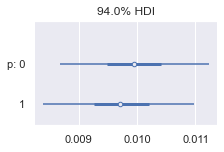

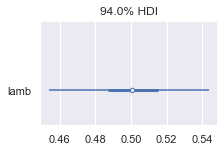

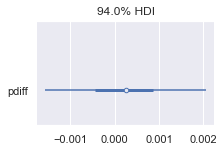

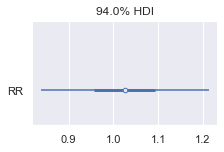

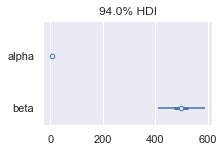

In [5]:
with model_a:
    pm.plot_forest(trace_a, var_names=["p"], combined=True, figsize=(3,2))
    pm.plot_forest(trace_a, var_names=["lamb"], combined=True, figsize=(3,2))
    pm.plot_forest(trace_a, var_names=["pdiff"], combined=True, figsize=(3,2))
    pm.plot_forest(trace_a, var_names=["RR"], combined=True, figsize=(3,2))
    pm.plot_forest(trace_a, var_names=["alpha","beta"], combined=True, figsize=(3,2))

Text(0.5, 0.98, 'Estimates for Parameters')

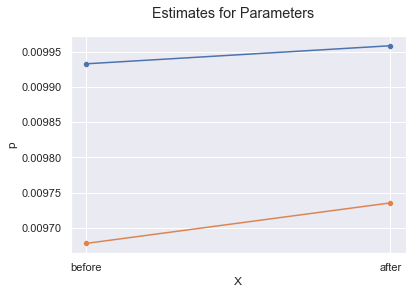

In [6]:
with model_a:
    post = pm.sample_posterior_predictive(trace_a, var_names=["p"])

points_0 = {"X": ["before","after"], "p": [y_[0]/n_[0],np.mean(post["p"][:,0])]}
points_1 = {"X": ["before","after"], "p": [y_[1]/n_[1],np.mean(post["p"][:,1])]}

sns.scatterplot(data=points_0, x="X", y="p")
sns.scatterplot(data=points_1, x="X", y="p")
plt.plot(points_0["X"], points_0["p"])
plt.plot(points_1["X"], points_1["p"])
plt.suptitle("Estimates for Parameters")

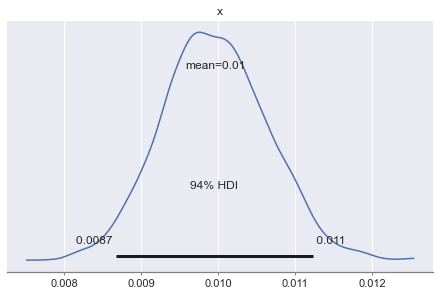

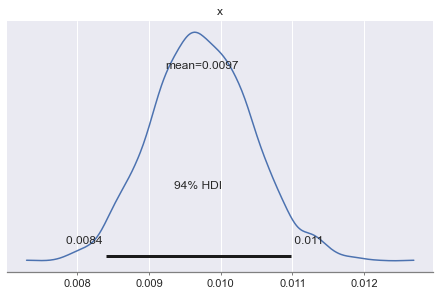

In [7]:
with model_a:
    pm.plot_posterior(post["p"][:,0])
    pm.plot_posterior(post["p"][:,1])

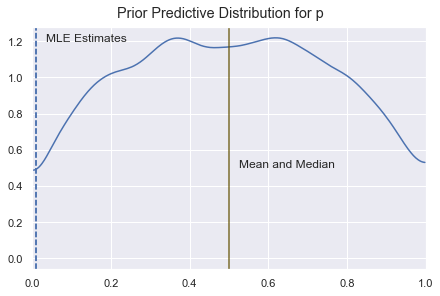

In [8]:
with pm.Model() as model_b:

    Y = pm.Data("Y", y_)
    N = pm.Data("N", n_)

    kappa = pm.Gamma("concentration", alpha=1, beta=1)
    omega = pm.Beta("omega", alpha=1, beta=1)

    alpha = pm.Deterministic("alpha", omega*(kappa+2)+1)
    beta = pm.Deterministic("beta", (1-omega)*(kappa+2)+1)
    
    # Priors
    p = pm.Beta("p", alpha=alpha, beta=beta, shape=2)

    # Calculations of interest
    pdiff = pm.Deterministic("pdiff", p[0] - p[1])
    RR = pm.Deterministic("RR", p[0]/p[1])

    _ = pm.Binomial("y", n=N, p=p, observed=Y)

    prior_checks = pm.sample_prior_predictive(samples=6000)
    pm.plot_dist(prior_checks["p"])
    plt.axvline(y_[0] / n_[0], linestyle="--")
    plt.axvline(y_[1] / n_[1], linestyle="--")
    plt.text(y_[1] / n_[1] + 0.025, 1.2, "MLE Estimates")
    plt.axvline(np.median(prior_checks["p"]), color="red", alpha=0.5)
    plt.axvline(np.mean(prior_checks["p"]), color="green", alpha=0.5)
    plt.text(np.mean(prior_checks["p"])+0.025, 0.5, "Mean and Median")

    plt.suptitle("Prior Predictive Distribution for p")
    plt.xlim(0.0,1.0)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_27553/1205180793.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_b = pm.sample(target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, omega, concentration]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warni

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 85 seconds.


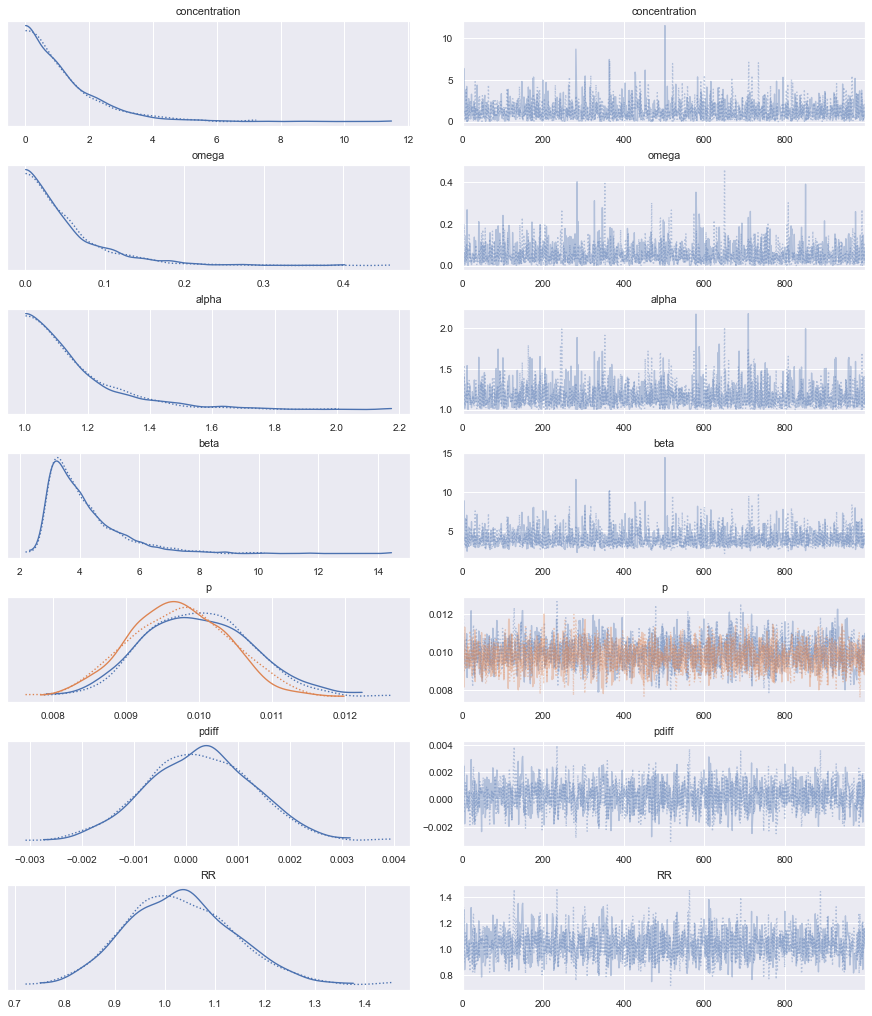

In [9]:
with model_b:
    trace_b = pm.sample(target_accept=0.9)
    pm.plot_trace(trace_b)

Text(0.5, 0.98, 'Estimates for Parameters')

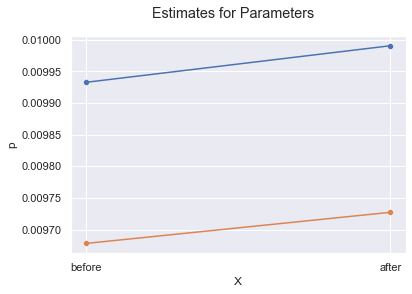

In [10]:
with model_b:
    post = pm.sample_posterior_predictive(trace_b, var_names=["p"])

points_0 = {"X": ["before","after"], "p": [y_[0]/n_[0],np.mean(post["p"][:,0])]}
points_1 = {"X": ["before","after"], "p": [y_[1]/n_[1],np.mean(post["p"][:,1])]}

sns.scatterplot(data=points_0, x="X", y="p")
sns.scatterplot(data=points_1, x="X", y="p")
plt.plot(points_0["X"], points_0["p"])
plt.plot(points_1["X"], points_1["p"])
plt.suptitle("Estimates for Parameters")

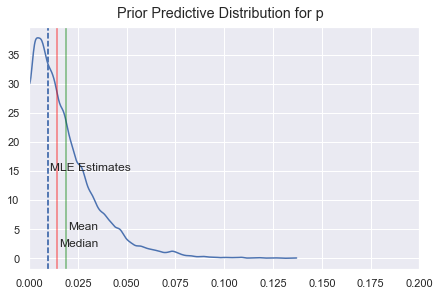

In [11]:
with pm.Model() as model_c:

    Y = pm.Data("Y", y_)
    N = pm.Data("N", n_)

    kappa = pm.Gamma("concentration", alpha=100, beta=1)
    omega = pm.Beta("omega", alpha=1, beta=100)

    alpha = pm.Deterministic("alpha", omega*(kappa+2)+1)
    beta = pm.Deterministic("beta", (1-omega)*(kappa+2)+1)
    
    # Priors
    p = pm.Beta("p", alpha=alpha, beta=beta, shape=2)

    # Calculations of interest
    pdiff = pm.Deterministic("pdiff", p[0] - p[1])
    RR = pm.Deterministic("RR", p[0]/p[1])

    _ = pm.Binomial("y", n=N, p=p, observed=Y)

    prior_checks = pm.sample_prior_predictive(samples=6000)
    pm.plot_dist(prior_checks["p"])
    plt.axvline(y_[0] / n_[0], linestyle="--")
    plt.axvline(y_[1] / n_[1], linestyle="--")
    plt.text(y_[1] / n_[1] + 0.001, 15, "MLE Estimates")
    plt.axvline(np.median(prior_checks["p"]), color="red", alpha=0.5)
    plt.axvline(np.mean(prior_checks["p"]), color="green", alpha=0.5)
    plt.text(np.mean(prior_checks["p"])+0.001, 5, "Mean")
    plt.text(np.median(prior_checks["p"])+0.001, 2, "Median")

    plt.suptitle("Prior Predictive Distribution for p")
    plt.xlim(0.0,0.2)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_27553/2684301447.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_c = pm.sample(target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, omega, concentration]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warni

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 90 seconds.


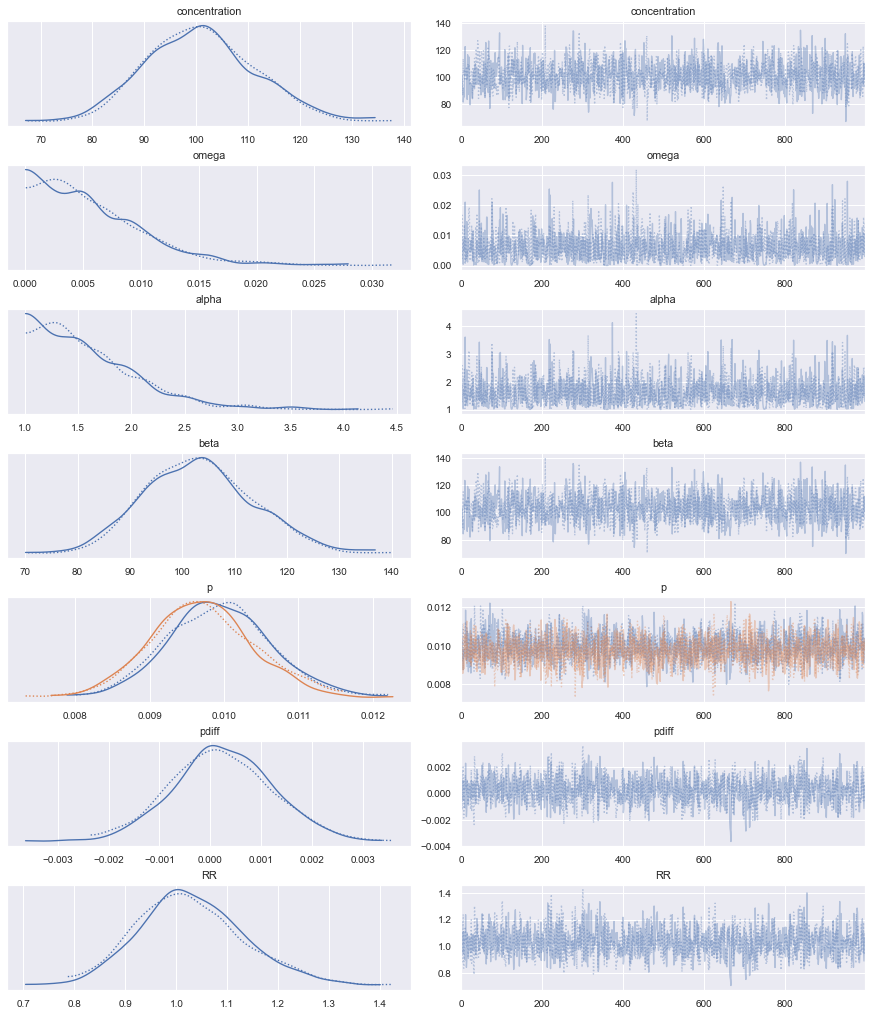

In [12]:
with model_c:
    trace_c = pm.sample(target_accept=0.9)
    pm.plot_trace(trace_c)

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

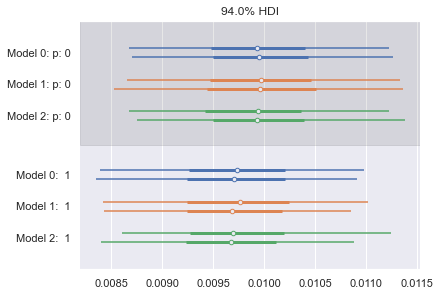

In [13]:
pm.plot_forest([trace_a, trace_b, trace_c], var_names=["p"], figsize=(6,4))

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

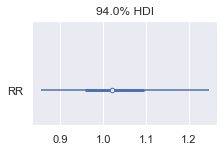

In [16]:
pm.plot_forest(trace_c, var_names=["RR"], combined=True, figsize=(3,2))